# Positional Encoding notebook

In [67]:
batch_size = 10
max_len = 32
d_model = 16
vocab_size = 52
dropout_prob = 0.2

In [68]:
dummy_text_sample = torch.randint(vocab_size, size=(batch_size, max_len))
embedding = nn.Embedding(vocab_size, d_model)
x_embed = embedding(dummy_text_sample)
x_embed.shape

torch.Size([10, 32, 16])

In [86]:
class PositionalEncoding(nn.Module):
    """Encodes the positional along the sequence to vector of size n_dim, corresponding
    to the input embedding dimension
    """
    def __init__(self, d_model: int, dropout_prob: float, max_len: int):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        # without registering as buffer, pe.state_dict() be empty
        # we need `.state_dict()` when we load our model
        # This will not let it be inside `.parameters()`. 
        # if you want, use `.register_parameter` instead
        self.register_buffer('positional_encodings', 
                             self.get_positional_encoding(d_model, max_len))
        
    def forward(self, x: torch.Tensor):
        # This is wrong because we need to take into account variable sequence length
#         pos_emb = self.positional_encodings(x)  
        
        B,T,C = x.shape
        # Detach just to remove it from computational graph. required_grad =False to make sure
        # But, x.data is the old way (notation), and x.detach() is the new way.
        pe = self.positional_encodings[:,:T, :].detach().requires_grad_(False)
        x = x + pe
        x = self.dropout(x)
        return x
                             
    def get_positional_encoding(self, d_model: int, max_len: int):
        pos_emb = torch.zeros((max_len, d_model))
        dims = torch.arange(0, d_model,2)
        pos = torch.arange(0, max_len) # (max_len,)
        # multiplication_term = np.exp(-2*dims/d_model * np.log(10000))
        multiplication_term = torch.exp(-dims/d_model * math.log(10000))
        pos_emb[:, ::2] = torch.sin(pos.reshape(-1,1) * multiplication_term)
        pos_emb[:,1::2] = torch.cos(pos.reshape(-1,1) * multiplication_term)
        ## make sure that the requires grad is False
        pos_emb = pos_emb.unsqueeze(0).requires_grad_(False) # for batch_dim
        return pos_emb
    
pe = PositionalEncoding(d_model=d_model, dropout_prob=dropout_prob, max_len=max_len)
pe(x_embed).requires_grad

True

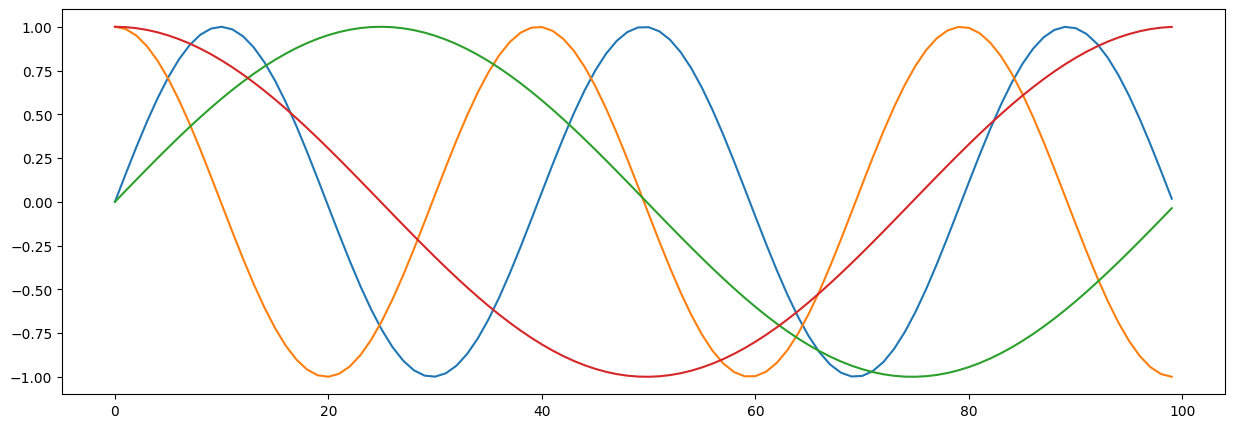

In [88]:
## visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
pos_en = pe.get_positional_encoding(20, 100) # (B,T)
plt.plot(np.arange(100), pos_en[0,:,4:8])